In [ ]:
from signals import *
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
from indicators import CCI, SuperTrend
from matplotlib import pyplot as plt
from math import exp, log

%matplotlib inline

df = load_ticker("EURUSD", 60)
begin = df.index[0]
end = df.index[-1]
days = (end-begin).days
all_months = days * 12 / 365


### Single Supertrend Signal

403 Trades, Win Ratio = 0.63
£141,244.08, 13.9 months @ 42.8%


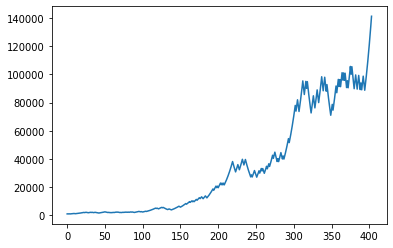

In [48]:
def supertrend_signals(ticker, frequency, multiplier, period, cci_period,
                       take_profit, stop_loss, verbose=False, 
                       risk=0.05, date=None, 
                       tp_follow=False, sl_follow=False):

    period = int(period)
    cci_period = int(period)
    balance = 1000
    ST = 0
    last_ST = 0
    last_CCI = 0
    signal = 0
    stance = 0
    take_profit_price = None
    stop_loss_price = None
    entry = None
    entry_date = None
    profit_pips = 0.0
    win = 0
    loss = 0
    profits = []
    balances = [balance]
    risk_stop_loss = stop_loss
        
    # TODO: average spread per ticker
    spread = 2.0 / pip_factor(ticker)
    fee_pounds_per_lot = 4

    df = load_ticker(ticker, frequency)
    if date:
        df = df.loc[date]
    
    trend_col_name = 'STX'
    SuperTrend(df, period, multiplier)
    cci_col_name = 'CCI'
    CCI(df, cci_period)

    for dt, row in df.iterrows():
        signal = 0
        
        ST_val = row[trend_col_name]            
        CCI_val = row[cci_col_name]
            
        if CCI_val > -100 and last_CCI < -100 and ST_val > 0:
            signal = 1
        elif CCI_val < 100 and last_CCI > 100 and ST_val < 0:
            signal = -1
            
        last_ST = ST_val
        last_CCI = CCI_val
        
        def close_buy(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (exit_price - entry) * pip_factor(ticker)
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = (risk * balance) / (risk_stop_loss + spread)
            lots = pounds_per_pip/10.
            fees = lots * fee_pounds_per_lot
            balance += (pounds_per_pip * trade_profit) - fees
            balances.append(balance)
            
            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                
            if verbose > 1:
                print(f"{entry_date.date()} -> {dt.date()}: Buy : balance = £{balance:,.0f}, {trade_profit:.0f} pips, Lots = {pounds_per_pip/10:.2f}")
            
        def close_sell(exit_price):
            nonlocal profit_pips, profits, entry, win, loss, balance
            if entry is None:
                return
            trade_profit = (entry - exit_price) * pip_factor(ticker)
            profit_pips += trade_profit
            profits.append(trade_profit)
            
            pounds_per_pip = (risk * balance) / (risk_stop_loss + spread)
            lots = pounds_per_pip/10.
            fees = lots * fee_pounds_per_lot
            balance += (pounds_per_pip * trade_profit) - fees    
            balances.append(balance)

            entry = None

            if trade_profit > 0:
                win += 1
            else:
                loss += 1
                        
            if verbose > 1:
                print(f"{entry_date.date()} -> {dt.date()}: Sell: balance = £{balance:,.0f} {trade_profit:.0f} pips, Lots = {pounds_per_pip/10:.2f}")
                                
                                    
        def open_buy(price, dt):
            nonlocal entry, take_profit_price, stop_loss_price, stance, entry_date
            entry = price
            take_profit_price = entry + (take_profit/pip_factor(ticker))
            stop_loss_price = entry - (stop_loss/pip_factor(ticker))
            stance = 1
            entry_date = dt
            
        def open_sell(price, dt):
            nonlocal entry, take_profit_price, stop_loss_price, stance, entry_date
            entry = price
            take_profit_price = entry - (take_profit/pip_factor(ticker))
            stop_loss_price = entry + (stop_loss/pip_factor(ticker))
            stance = -1
            entry_date = dt
            
        if stance > 0:
            if row.High > take_profit_price:
                stance = 0
                close_buy(take_profit_price)
                if tp_follow:
                    open_buy(take_profit_price + spread, dt)
                    
            if row.Low < stop_loss_price:
                stance = 0
                close_buy(stop_loss_price)
                if sl_follow:
                    open_buy(stop_loss_price + spread, dt)

        elif stance < 0:
            if row.Low < take_profit_price:
                stance = 0
                close_sell(take_profit_price)
                if tp_follow:
                    open_sell(take_profit_price + spread, dt)

            if row.High > stop_loss_price:
                stance = 0
                close_sell(stop_loss_price)
                if sl_follow:
                    open_sell(stop_loss_price + spread, dt)
                    
        ##### Also close with SL ####
        if stance != ST_val:
            if stance > 0:
                close_buy(row.Close)
                stance = 0
            if stance < 0:
                close_sell(row.Close)
                stance = 0
            
        if signal != 0 and stance != signal:
            if signal == 1:
                if stance == -1:
                    close_sell(row.Close)
                open_buy(row.Close + spread, dt)

            if signal == -1:
                if stance == 1:
                    close_buy(row.Close)
                open_sell(row.Close + spread, dt)
                
    win_ratio = 1.*win/(win+loss)

    if verbose > 0:
        print(f"{win + loss} Trades, Win Ratio = {win_ratio:.2}")
        #plt.hist(profits, bins=20)
        plt.plot(balances)
        
    if verbose != 0:
        return -balance
    else:
        return -((balance-1000) * win_ratio) / all_months
        #return win-loss
        #return -balance
        #return -profit_pips / stop_loss # Minimise stop loss
        #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
        #return -1.*win/(win+loss)  

eurusd = {'ticker': "EURUSD", "frequency": 60, # 75% £39,190.47
          'cci_period': 147.0, 'multiplier': 3.5, 'period': 8.0, 'stop_loss': 34.0, 'take_profit': 29.0}
eurjpy = {'ticker': 'EURJPY','frequency': 60,  # 21% £83,324.75
          'cci_period': 91.0, 'multiplier': 28.0, 'period': 199.0, 'stop_loss': 12.0, 'take_profit': 240.0}
audusd = {'ticker': 'AUDUSD','frequency': 60, # 65% £16,120
          'cci_period': 23.0, 'multiplier': 2.1, 'period': 5.0, 'stop_loss': 18.0, 'take_profit': 18.0} # 8315
audcad = {'ticker': 'AUDCAD','frequency': 60, # 63% £141,244.08
          'cci_period': 104.0, 'multiplier': 40, 'period': 8.0, 'stop_loss': 10.0, 'take_profit': 11.0}

final_balance = -supertrend_signals(**audcad, verbose=1)
monthly_percent_return = (exp(log(final_balance/1000)/all_months)-1.0)*100
print(f"£{final_balance:,.2f}, {all_months:.1f} months @ {monthly_percent_return:.1f}%")


In [44]:
def search_for(ticker):

    def objective(params):
        return supertrend_signals(ticker=ticker, frequency=60, **params)
    

    space = {'multiplier': hp.quniform('multiplier', 2, 50, 0.1),
             'period': hp.quniform('period', 2, 200, 1),
             'cci_period': hp.quniform('cci_period', 2, 200, 1),
             'take_profit': hp.quniform('take_profit', 10, 50, 1),
             'stop_loss': hp.quniform('stop_loss', 10, 50, 1)
            }
    print(f"{ticker}:")
    for _ in range(3):
        print(fmin(objective, space, algo=tpe.suggest, max_evals=5120))


In [45]:
search_for("EURUSD")
search_for("AUDCAD")
search_for("EURAUD")
search_for("EURCHF")
search_for("EURGBP")
search_for("GBPJPY")
search_for("GBPUSD")
search_for("USDCAD")
search_for("USDCHF")
search_for("USDJPY")
search_for("AUDUSD")
search_for("EURJPY")

# TODO: Second derivative of result wrt each parameter, want to minimise that to to avoid the 'edges'
# TODO: Bucket trades into bins and work out the sharpe ratio and the 


EURUSD:
 99%|█████████▉| 5063/5120 [3:07:54<02:06,  2.23s/trial, best loss: -2981.03451669653]   


KeyboardInterrupt: 

### Grid search for SL + TP

In [ ]:
def find_levels(ticker, frequency, multiplier, period, verbose=False):
    tps = list(range(50, 260, 10))
    sls = list(range(10, 60, 10))
    pfs = np.empty((len(sls), len(tps)))

    for t_idx, tp in enumerate(tps):
        for s_idx, sl in enumerate(sls):
            one_hour["take_profit"] = tp
            one_hour["stop_loss"] = sl
            pf = supertrend_signals(**one_hour, tp_follow=True)
            pfs[s_idx][t_idx] = -pf
    return tps, sls, pfs

In [ ]:
tps, sls, pfs = find_levels(ticker="EURUSD", frequency=60, multiplier=4.8, period=63)

In [ ]:
plt.figure(figsize=(100,10))
fig, ax = plt.subplots()
CS = ax.contour(tps, sls, pfs)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=pfs, x=tps, y=sls)])
fig.show()

### Line search for Period

In [ ]:
periods = range(50, 90, 1)
balances = []
for period in periods:
    balances.append(-supertrend_signals("EURUSD", frequency=60, multiplier=4.8, period=period, 
                          take_profit=127, stop_loss=46, verbose=False, risk=0.05))
plt.plot(periods, balances)

### Line search for Multiplier

In [ ]:
multipliers = [x/10. for x in range(40, 61)]
balances = []
for multiplier in multipliers:
    balances.append(-supertrend_signals("EURUSD", frequency=60, multiplier=multiplier, period=63, 
                          take_profit=127, stop_loss=46, verbose=False, risk=0.05))
plt.plot(multipliers, balances)

### Optimal Risk analysis

In [ ]:
risks = [x/100. for x in range(1, 100)]
balances = []
for risk in risks:
    balances.append(-supertrend_signals(**one_sec, risk=risk))
plt.plot(risks, balances)

##     #return -profit_pips
    #return -profit_pips / stop_loss # Minimise stop loss
    #return -np.mean(profits)/np.std(profits) # Sharpe Ratio
    #return -1.*win/(win+loss)   

Balance 5705, 5% risk
print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=63, take_profit=123, stop_loss=21, verbose=False))

#Profit (30 mins) 2019
#print(-supertrend_signals(ticker, frequency=30, multiplier=8, period=110, take_profit=120, stop_loss=70, verbose=True))

Profit (60 mins) 2081
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=123, stop_loss=75, verbose=True))

Sharpe Ratio (0.69) 1416
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=53, take_profit=47, stop_loss=199, verbose=True))

Stop loss reduced profit 849
#print(-supertrend_signals(ticker, frequency=60, multiplier=5, period=54, take_profit=72, stop_loss=28, verbose=True))

In [ ]:
def meta_super_trend(df, sample_mins, period, multiplier):

    ohlc_dict = {'Open':'first', 'High':'max', 'Low':'min', 'Close': 'last'}
    base_interval = (df.index[1]-df.index[0]).components.minutes
    dfs = []
    for base in range(0, sample_mins, base_interval):
        tmp = df.resample(f"{sample_mins}Min", base=base).apply(ohlc_dict).dropna()
        SuperTrend(tmp, period, multiplier, prefix=sample_mins)
        dfs.append(tmp)

    return pd.concat(dfs).sort_index()